# Sales funnels and A/A/B test results analysis

There's a startup that sells food products. We need to investigate user behavior for the company's app.
First we'll study the sales funnel. We'll find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?  
Then we'll look at the results of an A/A/B test. The designers would like to change the fonts for the entire app, so it was decided to make a decision based on the results of an A/A/B test.
The users were splitted into three groups: two control groups get the old fonts and one test group gets the new ones. We'll find out which set of fonts produces better results.

**Project Steps** <a class="anchor" id="table_of_contents"></a>  
[Data file and general information](#chapter1)  
[Studying the data](#chapter2)  
[Studying the event funnel](#chapter3)  
[Studying the results of the experiment](#chapter4)  
[General conclusions](#chapter5)

## 1. Data file and general information
<a class="anchor" id="chapter1"></a>

In [2]:
#import libraries of functions
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats as st
import math as mth

#ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
        
#open the data file locally
try:
    data = pd.read_csv('logs_exp_us.csv', sep = '\t')
    
#open the data file on the platform    
except:
    data = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')

In [3]:
#show general info
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


##### data description:
- `EventName` — event name
- `DeviceIDHash` — unique user identifier
- `EventTimestamp` — event time
- `ExpId` — experiment number: 246 and 247 are the control groups, 248 is the test group

We'll rename the columns names for our convinience:

In [4]:
data.columns = ['event_name','uid','event_ts','exp_id']
#names of columns, types and counts
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   uid         244126 non-null  int64 
 2   event_ts    244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


We see that the names of the columns were updated and we don't have any missing values. There are some changes that need to be done. We need to change the type of `event_ts` to datetime and create additional column for the date, to ease the calculations. As the id's are nut used for numeric calculations, we'll change the `exp_id` column to 'object' type.

In [5]:
data['event_ts'] = pd.to_datetime(data['event_ts'], unit='s')
data['exp_id'] = data['exp_id'].astype('object')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   uid         244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 29.4 MB


In [6]:
data['date'] = data['event_ts'].astype('datetime64[D]')
data.head()

,event_name,uid,event_ts,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [7]:
#show statistical summary
display(data['event_ts'].describe(), data['event_name'].describe(), data['exp_id'].describe())

count                  244126
unique                 176654
top       2019-08-04 16:23:19
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_ts, dtype: object

count               244126
unique                   5
top       MainScreenAppear
freq                119205
Name: event_name, dtype: object

count     244126
unique         3
top          248
freq       85747
Name: exp_id, dtype: int64

In [8]:
print('The number of unique users:', data.uid.nunique())

The number of unique users: 7551


- The data spans from 2019-07-25 to 2019-08-07 (two weeks)
- There are 7551 unique users.
- The biggest group is 248, the test group.
- There are 5 possible events and the most common one is 'MainScreenAppear'.

Now we'll check if there are any duplicates. If there are, we'll need to remove them and update the data engineers so they'll find what caused it.

In [9]:
#count the duplicated rows
print('Number of duplicated rows:',data.duplicated().sum())
print('The share of duplicated rows from the whole dataset:',(data.duplicated().sum()/len(data)).round(3))

Number of duplicated rows: 413
The share of duplicated rows from the whole dataset: 0.002


The share of the duplicated rows is very small. We'll remove them but first we'll try to understand the cause. Maybe we had problems with the platform.

In [10]:
for i in data[data.duplicated()].columns:
    print(i,':', data[data.duplicated()][i].nunique())

event_name : 5
uid : 237
event_ts : 352
exp_id : 3
date : 9


In [11]:
data[data.duplicated()]['date'].unique()

array(['2019-07-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-06T00:00:00.000000000',
       '2019-08-07T00:00:00.000000000'], dtype='datetime64[ns]')

The duplicates are not related to one of the groups or a specific type of event. It seems that there might be a technical problem as the duplicates are in Consecutive days from 2019-07-30 to 2019-08-07. As we mentioned before, we are going to delete those rows.

In [12]:
#remove duplicated rows
data.drop_duplicates(inplace=True)

We also want to make sure that each group has unique users (there are no users that were assigned to more than one group)

In [13]:
#count the nuber of groups assigned for each user
n_groups = data.groupby('uid').agg({'exp_id':'nunique'})
n_groups = n_groups[n_groups['exp_id']>1].reset_index()
print('The amount of unique users that were assigned for more than one group: {}'.format(len(n_groups)))

The amount of unique users that were assigned for more than one group: 0


We see that:

- Data types are correct.
- There's no missing values.
- The date span is 2019-07-25 to 2019-08-07, total of 14 days.
- There were some duplicated rows in specific days' we need to inform our data engineers for additional investigation.
- There are 5 possible actions and the most common one is 'MainScreenAppear'.
- There are more members in the test group.

Now we are ready for our analysis.

## 2. Studying the data
<a class="anchor" id="chapter2"></a>

- **How many events are in the logs?**

In [14]:
print('Number of events in the logs:',data.event_name.count())

Number of events in the logs: 243713


- **How many users are in the logs?**

In [15]:
print('Number of users in the log:',data.uid.nunique())

Number of users in the log: 7551


- **What's the average number of events per user?**

In [16]:
data.groupby(['uid'])['event_name'].nunique().reset_index()['event_name'].value_counts()

4    3035
1    2707
2    1021
5     471
3     317
Name: event_name, dtype: int64

Most of users have 4 events.

In [17]:
print('Average number of actions per user: {:.2f}'.format(data.groupby(['uid'])['event_name'].count().mean()))

Average number of actions per user: 32.28


- **What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?**

As we mentioned. the data covers the dates 2019-07-25 to 2019-08-07. Let's plot the histogram for a clear understanding.

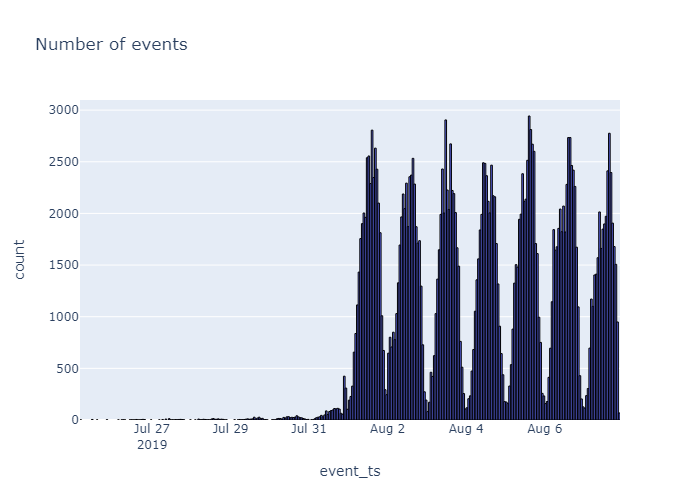

In [18]:
fig = px.histogram(data[['event_ts','event_name']], x="event_ts", title ='Number of events')
fig.update_traces(marker = dict(line = dict(color='#000000', width =1)))
fig.show("png")

The relevant period in that case is 2019-08-01 to 2019-08-07. We'll need to remove those older records that were with a very small volume due to a technical issue or even influation of the marketing. We see the daily cycles. The peak of activity is during the day and the activity is very small in the evening and at night.

In [19]:
#creat a copy of the data so it could be manipulated without affecting the original data
original_copy = data.copy(deep=True)
#save the relevant period
data = data[data['date'] > '2019-07-31']

- **Did you lose many events and users when excluding the older data?**

In [20]:
print('Percenatge of removed events from the logs: {:.2%}'.format(1-data.event_name.count()/original_copy.event_name.count()))
print('Percenatge of removed users from the log: {:.2%}'.format(1-data.uid.nunique()/original_copy.uid.nunique()))

print('Average number of actions per user: {:.2f}'.format(data.groupby(['uid'])['event_name'].count().mean()))

Percenatge of removed events from the logs: 1.16%
Percenatge of removed users from the log: 0.23%
Average number of actions per user: 31.97


We see that the volume of removed data is very low.

- **Make sure you have users from all three experimental groups.**

In [21]:
print('Number of users in the first control group:',data[data['exp_id']==246].uid.nunique())
print('Number of users in the second control group:',data[data['exp_id']==247].uid.nunique())
print('Number of users in the test group:',data[data['exp_id']==248].uid.nunique())
print('Total number of unique users:', data.uid.nunique())

Number of users in the first control group: 2484
Number of users in the second control group: 2513
Number of users in the test group: 2537
Total number of unique users: 7534


All the groups are represented with a very similar numbers.

**Conclusions**

- There are 5 types of events.
- There were some logs before August 1 that were removed due to a low amount (maybe due to a technical issue).
- We have after removing the old data, 7534 unique users.
- Each user take about 32 actions.

## 3. Studying the event funnel
<a class="anchor" id="chapter3"></a>

- **See what events are in the logs and their frequency of occurrence. Sort them by frequency.**

In [22]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

- **Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.**

In [23]:
#number of users who performed each of the events
data.groupby('event_name')['uid'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: uid, dtype: int64

In [24]:
#proportion of users who performed the action at least once
data.groupby(['event_name'])['uid'].nunique().sort_values(ascending=False)/data.uid.nunique()

event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: uid, dtype: float64

We would expect to get 1 for the 'MainScreenAppear' but maybe we drleted some old logs of this event for some of the users.

- **In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.**

As we can see above, the logic path (also based on the shares of users in each step) is:  
1) MainScreenAppear  
2) OffersScreenAppear  
3) CartScreenAppear  
4) PaymentScreenSuccessful  

Tutorial is optional but it is not obligatory for completing a purchase. We'll remove this step when calculating the funnel.

In [25]:
#remove the tutorial events
sorted_data = data[data['event_name']!='Tutorial'].sort_values(by=['uid','event_ts'])

Now we want to check what is the most common sequence of events.

In [26]:
#function for calculating the path of each user
def sequence(user):
    sorted_user = sorted_data[sorted_data['uid'] == user].sort_values(by=['uid','event_ts'])
    return sorted_user['event_name'].drop_duplicates().to_list()

In [27]:
events_sequence = []
for i in sorted_data.uid.unique():
    events_sequence.append([i,sequence(i)])

In [28]:
path_data = pd.DataFrame(events_sequence,columns=['user','path'])
path_data.head(10)

,user,path
0,6888746892508752,[MainScreenAppear]
1,6909561520679493,"[MainScreenAppear, PaymentScreenSuccessful, Ca..."
2,6922444491712477,"[MainScreenAppear, PaymentScreenSuccessful, Ca..."
3,7435777799948366,[MainScreenAppear]
4,7702139951469979,"[MainScreenAppear, OffersScreenAppear, CartScr..."
5,8486814028069281,"[OffersScreenAppear, CartScreenAppear, MainScr..."
6,8740973466195562,"[MainScreenAppear, OffersScreenAppear]"
7,9841258664663090,"[MainScreenAppear, OffersScreenAppear, CartScr..."
8,12692216027168046,"[MainScreenAppear, OffersScreenAppear]"
9,15708180189885246,"[OffersScreenAppear, CartScreenAppear, Payment..."


In [29]:
#count the number of users that took the same path
path_data['path'].apply(tuple).value_counts()

(MainScreenAppear,)                                                                  2882
(MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful)     905
(MainScreenAppear, OffersScreenAppear)                                                872
(MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear)     771
(MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear)     668
(MainScreenAppear, CartScreenAppear, PaymentScreenSuccessful, OffersScreenAppear)     510
(MainScreenAppear, CartScreenAppear, OffersScreenAppear, PaymentScreenSuccessful)     259
(MainScreenAppear, OffersScreenAppear, CartScreenAppear)                               92
(OffersScreenAppear, MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear)      65
(OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear, MainScreenAppear)      63
(MainScreenAppear, CartScreenAppear, OffersScreenAppear)                               52
(MainScree

Most of users saw only the 'MainScreenAppear' after that, the most common path is the full path!

- **Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)**

In [30]:
#number of users who performed each of the events
funnel_shift = sorted_data.groupby(['event_name'])['uid'].nunique().sort_values(ascending=False).reset_index()
funnel_shift

,event_name,uid
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [31]:
funnel_shift['change_pct'] = funnel_shift['uid'].pct_change()
funnel_shift

,event_name,uid,change_pct
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,-0.380914
2,CartScreenAppear,3734,-0.187024
3,PaymentScreenSuccessful,3539,-0.052223


Now we want to know the same but for each of the groups.

In [32]:
funnel_by_groups = []
for i in data.exp_id.unique():
    group = sorted_data[sorted_data.exp_id == i].groupby(['event_name','exp_id'])['uid'].nunique().reset_index().sort_values(by='uid',ascending=False)
    display(group)
    funnel_by_groups.append(group)

,event_name,exp_id,uid
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200


,event_name,exp_id,uid
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158


,event_name,exp_id,uid
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181


In [33]:
funnel_by_groups = pd.concat(funnel_by_groups)
funnel_by_groups

,event_name,exp_id,uid
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531


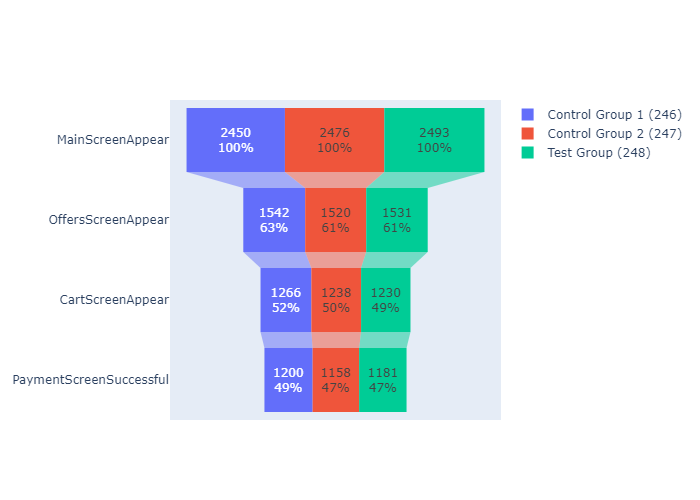

In [34]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Control Group 1 (246)',
    y = funnel_by_groups.query('exp_id == 246')['event_name'],
    x = funnel_by_groups.query('exp_id == 246')['uid'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    orientation = "h",
    name = 'Control Group 2 (247)',
    y = funnel_by_groups.query('exp_id == 247')['event_name'],
    x = funnel_by_groups.query('exp_id == 247')['uid'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    orientation = "h",
    name = 'Test Group (248)',
    y = funnel_by_groups.query('exp_id == 248')['event_name'],
    x = funnel_by_groups.query('exp_id == 248')['uid'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.show("png")

We see that the percentages for each of the steps is pretty similar between the groups. The best percentages with a tiny difference are for the first control group.

- **At what stage do you lose the most users?**

It seems that the biggest share that we lose is between the first and the second events (from 'MainScreenAppear' to 'OffersScreenAppear'), about 38% of usres from 'MainScreenAppear' event. Maybe if we'll have a shortcut to Quick Buy We can retain these customers.

- **What share of users make the entire journey from their first event to payment?**

The share of users that make the entire journey from their first event to payment is about 47%-49%. 

**Conclusions**

- The full path for a user is: 1) MainScreenAppear. 2) OffersScreenAppear. 3) CartScreenAppear. 4) PaymentScreenSuccessful.
- Most of users saw only the 'MainScreenAppear' after that, the most common path is the full path!
- We need to make more people to move to 'OffersScreenAppear' after 'MainScreenAppear', it seems that the ratios between the other stages are pretty good.

## 4. Studying the results of the experiment
<a class="anchor" id="chapter4"></a>

- **How many users are there in each group?**

In [35]:
data.groupby(['exp_id'])['uid'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: uid, dtype: int64

- **We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.  
  Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?**

First we'll organize the number of users in each event for each group.

In [36]:
pivot = sorted_data.pivot_table(
    index='event_name', columns='exp_id',values='uid',aggfunc=lambda x: x.nunique()).reset_index()
pivot

exp_id,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181


In [37]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    # number of users in a specified event in a specified group
    success1 = pivot[pivot.event_name == event][group1].iloc[0].sum()
    success2 = pivot[pivot.event_name == event][group2].iloc[0].sum()
    
    # total number of users in a specified group
    trials1 = data.query('exp_id in @group1')['uid'].nunique()
    trials2 = data.query('exp_id in @group2')['uid'].nunique()
    
    
    # success proportion in the first group:
    p1 = success1/trials1

    # success proportion in the second group:
    p2 = success2/trials2

    # success proportion in the combined dataset:
    p_combined = (success1 + success2) / (trials1 + trials2)

    # the difference between the datasets' proportions
    difference = p1 - p2
    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
    # calculating the statistic in standard deviations of the standard normal distribution

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event,"and groups", group1,group2)
    else:
        print("Failed to reject the null hypothesis for",event,"and groups", group1,group2 )

In this case the hypothesis are as follow:
- $H_0$ : $\pi$(event in group 1) = $\pi$(event in group 2)  
- $H_a$ : $\pi$(event in group 1) != $\pi$(event in group 2)

In [38]:
# apply the function for all the events
for i in pivot.event_name.unique():
    check_hypothesis([246],[247],i,alpha=0.05)

p-value:  0.22883372237997213
Failed to reject the null hypothesis for CartScreenAppear and groups [246] [247]
p-value:  0.7570597232046099
Failed to reject the null hypothesis for MainScreenAppear and groups [246] [247]
p-value:  0.2480954578522181
Failed to reject the null hypothesis for OffersScreenAppear and groups [246] [247]
p-value:  0.11456679313141849
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246] [247]


As we are checking both of the control groups, the expected results are that we won't find any statistically significant difference between samples 246 and 247, and that exactly what we got, so we can conclude that our mechanisms and calculations work just fine and we can apply the test for the test group!

- **Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?**

In [39]:
for i in pivot.event_name.unique():
    check_hypothesis([246],[248],i,alpha=0.05)

p-value:  0.07842923237520116
Failed to reject the null hypothesis for CartScreenAppear and groups [246] [248]
p-value:  0.2949721933554552
Failed to reject the null hypothesis for MainScreenAppear and groups [246] [248]
p-value:  0.20836205402738917
Failed to reject the null hypothesis for OffersScreenAppear and groups [246] [248]
p-value:  0.2122553275697796
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246] [248]


In [40]:
for i in pivot.event_name.unique():
    check_hypothesis([247],[248],i,alpha=0.05)

p-value:  0.5786197879539783
Failed to reject the null hypothesis for CartScreenAppear and groups [247] [248]
p-value:  0.4587053616621515
Failed to reject the null hypothesis for MainScreenAppear and groups [247] [248]
p-value:  0.9197817830592261
Failed to reject the null hypothesis for OffersScreenAppear and groups [247] [248]
p-value:  0.7373415053803964
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [247] [248]


In [41]:
for i in pivot.event_name.unique():
    check_hypothesis([246,247],[248],i,alpha=0.05)

p-value:  0.18175875284404386
Failed to reject the null hypothesis for CartScreenAppear and groups [246, 247] [248]
p-value:  0.29424526837179577
Failed to reject the null hypothesis for MainScreenAppear and groups [246, 247] [248]
p-value:  0.43425549655188256
Failed to reject the null hypothesis for OffersScreenAppear and groups [246, 247] [248]
p-value:  0.6004294282308704
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246, 247] [248]


We see that in all tests we get the same result - there is no statistically significant difference between samples 246, 247 and 248 which means we don't have difference between the control groups and the test group. The change of the font didn't have an affect on the conversion rate.

- **What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.**

The chosen significance level is 0.05.  
Using the Bonferonni correction, if we want an overall alpha to be 0.05, the significance level for each test will be 0.05 devided by the number of the tests. In our case it will be devided by 16 (4 groups combinations with 4 events in each):

0.05/16 = 0.003125

In [42]:
for i in pivot.event_name.unique():
    check_hypothesis([246],[247],i,alpha=0.05/16)

p-value:  0.22883372237997213
Failed to reject the null hypothesis for CartScreenAppear and groups [246] [247]
p-value:  0.7570597232046099
Failed to reject the null hypothesis for MainScreenAppear and groups [246] [247]
p-value:  0.2480954578522181
Failed to reject the null hypothesis for OffersScreenAppear and groups [246] [247]
p-value:  0.11456679313141849
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246] [247]


In [43]:
for i in pivot.event_name.unique():
    check_hypothesis([246],[248],i,alpha=0.05/16)

p-value:  0.07842923237520116
Failed to reject the null hypothesis for CartScreenAppear and groups [246] [248]
p-value:  0.2949721933554552
Failed to reject the null hypothesis for MainScreenAppear and groups [246] [248]
p-value:  0.20836205402738917
Failed to reject the null hypothesis for OffersScreenAppear and groups [246] [248]
p-value:  0.2122553275697796
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246] [248]


In [44]:
for i in pivot.event_name.unique():
    check_hypothesis([247],[248],i,alpha=0.05/16)

p-value:  0.5786197879539783
Failed to reject the null hypothesis for CartScreenAppear and groups [247] [248]
p-value:  0.4587053616621515
Failed to reject the null hypothesis for MainScreenAppear and groups [247] [248]
p-value:  0.9197817830592261
Failed to reject the null hypothesis for OffersScreenAppear and groups [247] [248]
p-value:  0.7373415053803964
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [247] [248]


In [45]:
for i in pivot.event_name.unique():
    check_hypothesis([246,247],[248],i,alpha=0.05/16)

p-value:  0.18175875284404386
Failed to reject the null hypothesis for CartScreenAppear and groups [246, 247] [248]
p-value:  0.29424526837179577
Failed to reject the null hypothesis for MainScreenAppear and groups [246, 247] [248]
p-value:  0.43425549655188256
Failed to reject the null hypothesis for OffersScreenAppear and groups [246, 247] [248]
p-value:  0.6004294282308704
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups [246, 247] [248]


We see that the results stay the same - there is no statistically significant difference between samples, which means that the change didn't encourage more customers to reach a state of purchase completion.

## 5. General conclusions
<a class="anchor" id="chapter5"></a>

The data we got was of a good quality. We had some old records we neede to remove that were not relevant for the period we were testing, maybe we can consult with the data engineers for more efficient way of saving relevant data.

We tested our mechanism and calculations with A/A test and tested our hypothesis with A/B tests. We found that **there is no statistically significant difference between samples, which means that the change didn't encourage more customers to reach a state of purchase completion.**